In [37]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
from datetime import datetime
import PPCA_MR as p
import statsmodels.api as sm
import quandl
token="Us3wFmXGgAj_1cUtHAAR"

In [41]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

# Hand cleansed
Hand cleaned to removed duplicates

In [3]:
cleansed=load_amihud_markets_price()

tsmom_model.py:160: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('./Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:162: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('./liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


# Dollar turnover

Looks terrible as the data quality is poor


$$  \sum {\text{dvol}_t} $$



In [5]:
dvol=calculate_dollar_volume(cleansed)

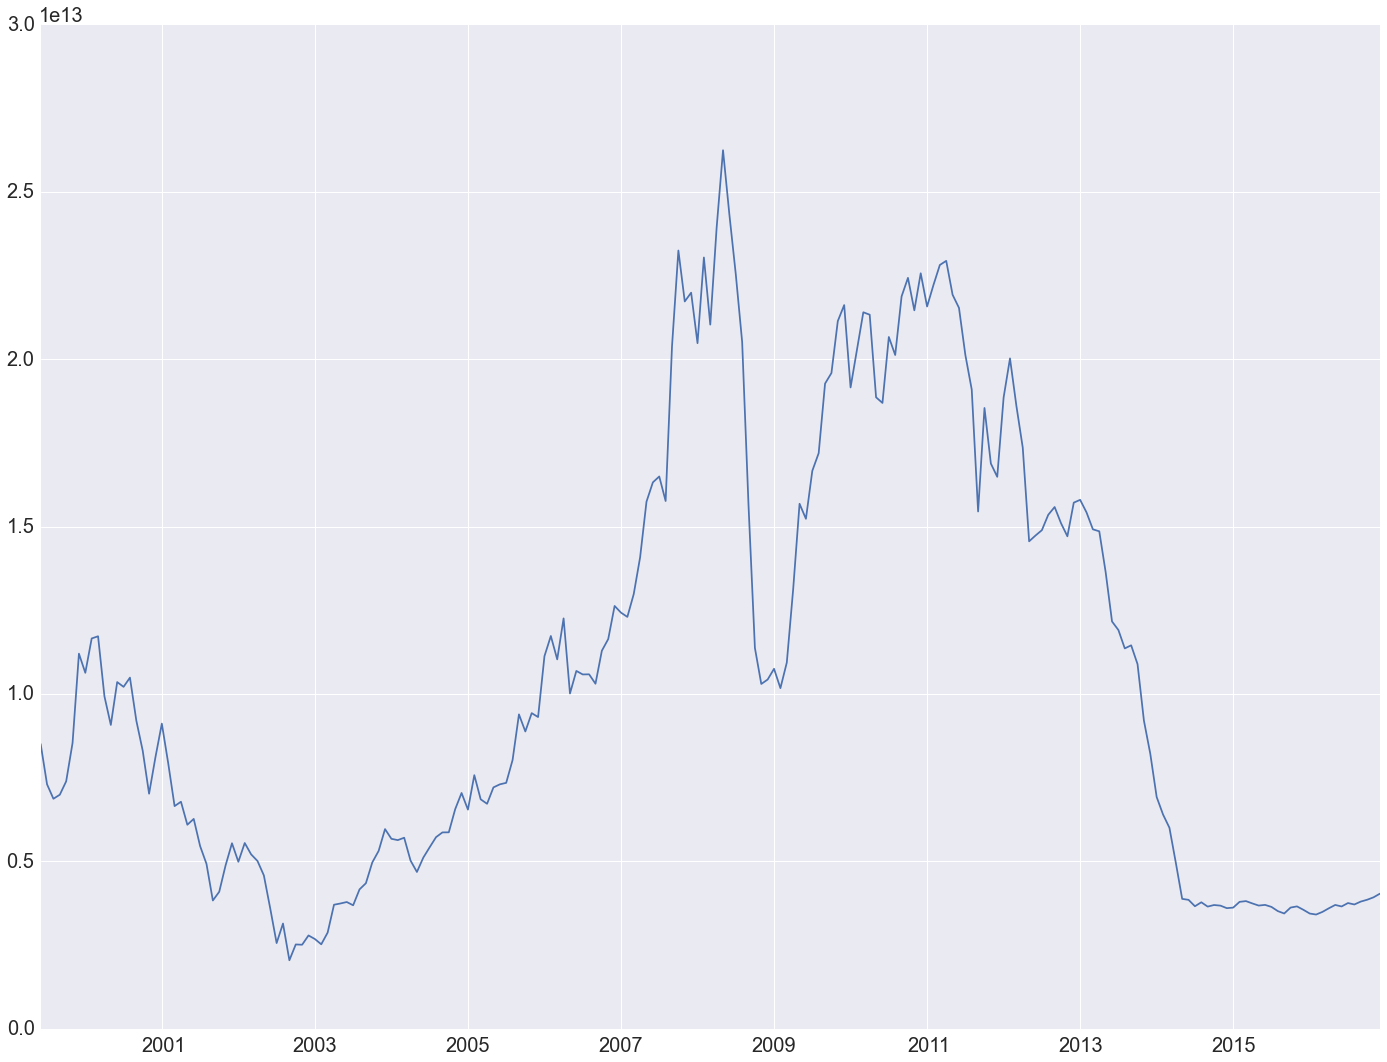

In [9]:
dvol.dropna(how='all').sum(axis=1).plot()

# Funding Rates

* TED spread

In [43]:
ted=quandl.get('FRED/TEDRATE').Value

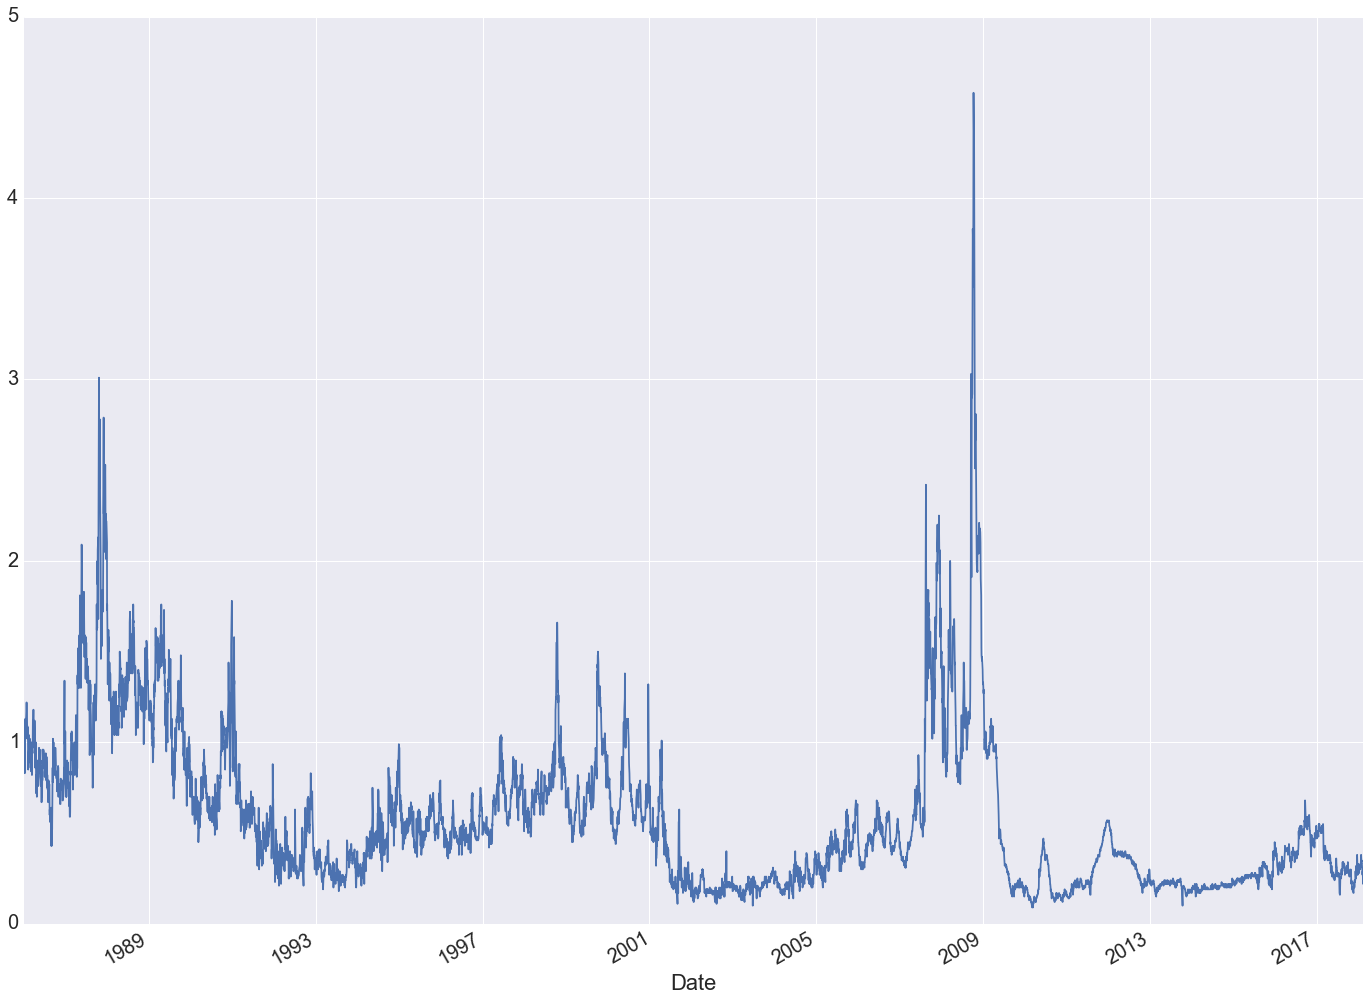

In [44]:
ted.plot()

# Swap versus cash financed

OIS - Tbills

* Missing OIS data

In [47]:
tbill=quandl.get('FRED/DTB3').Value

# Libor term repo

Overight - Repo rate

* Missing LIBOR O/N rate
* Ticker is FRED/USDONTDIS6N (or something similar)

In [115]:
repo=pd.read_csv('repo.csv',index_col=0,parse_dates=True)
# This needs to get replaced with 
libor_term_repo=(repo.TreasuryRepo-tbill).dropna()


# On the run versus off the run 

In [100]:
us10y_zero=quandl.get('FED/SVENY').SVENY10.resample(rule='d',how='last').dropna()
yield10=quandl.get('USTREASURY/YIELD')['10 YR'].resample(rule='d',how='last').dropna()
on_off=(us10y_zero-yield10).dropna()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  


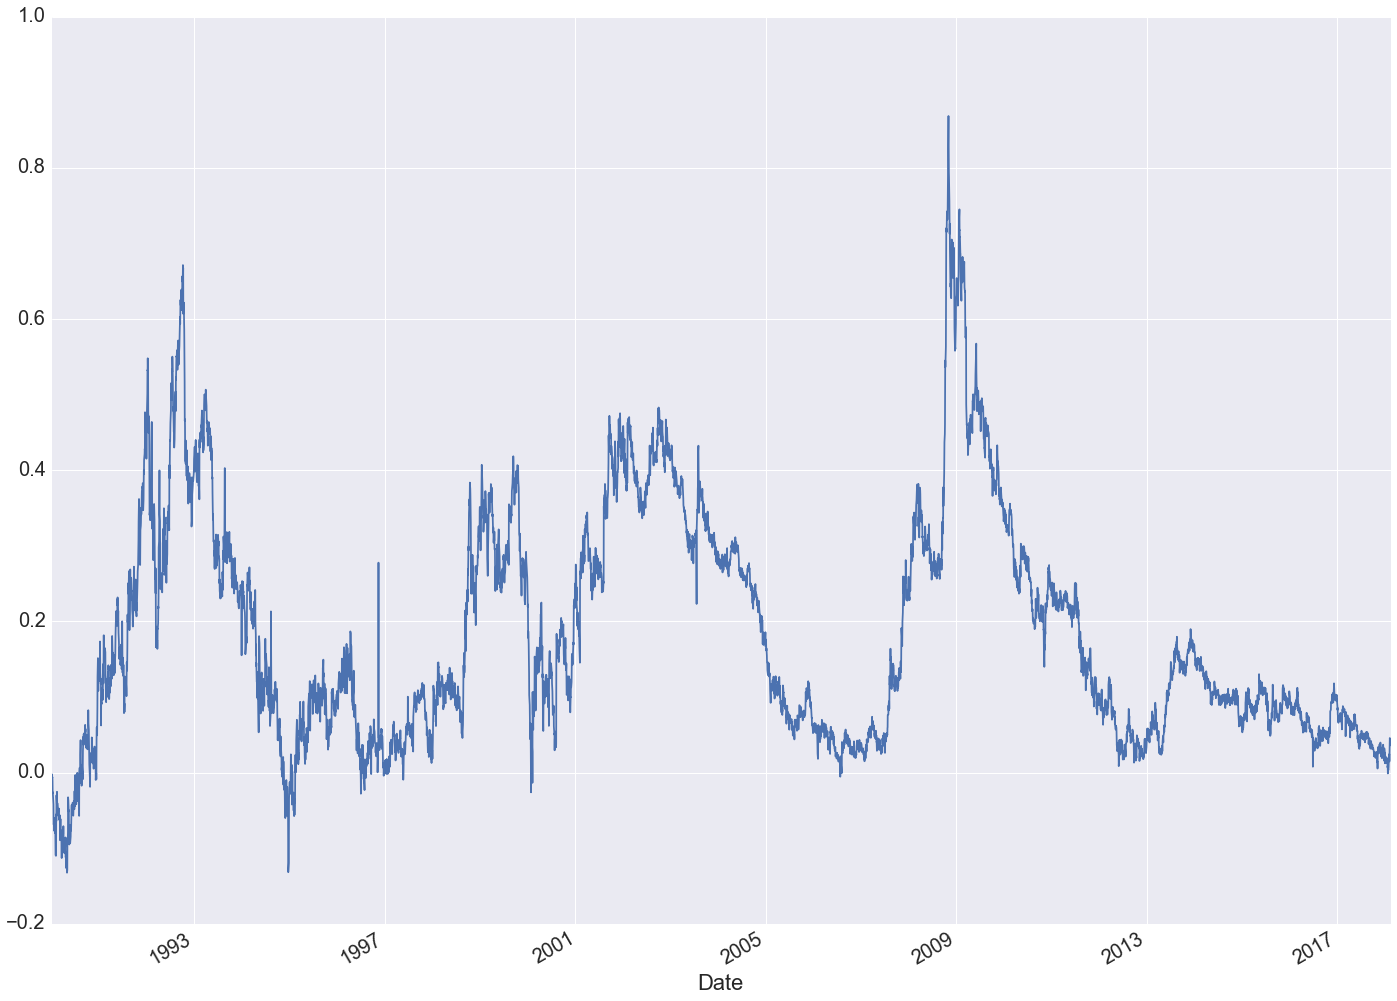

In [102]:
on_off.plot()

# Pastor and Stambagh  (2003)

https://faculty.chicagobooth.edu/lubos.pastor/research/liq_data_1962_2016.txt

In [73]:
PS=pd.read_csv('PS.csv',index_col=0,parse_dates=True).resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  """Entry point for launching an IPython kernel.


# Getting everything ready for regressions

In [131]:
funding_liquidity = pd.DataFrame()
market_liquidity = pd.DataFrame()
funding_liquidity['TED Spread']=ted.resample(rule='m',how='last')/100.
funding_liquidity['LIBOR term repo']=libor_term_repo.resample(rule='m',how='last')/100.


/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  after removing the cwd from sys.path.


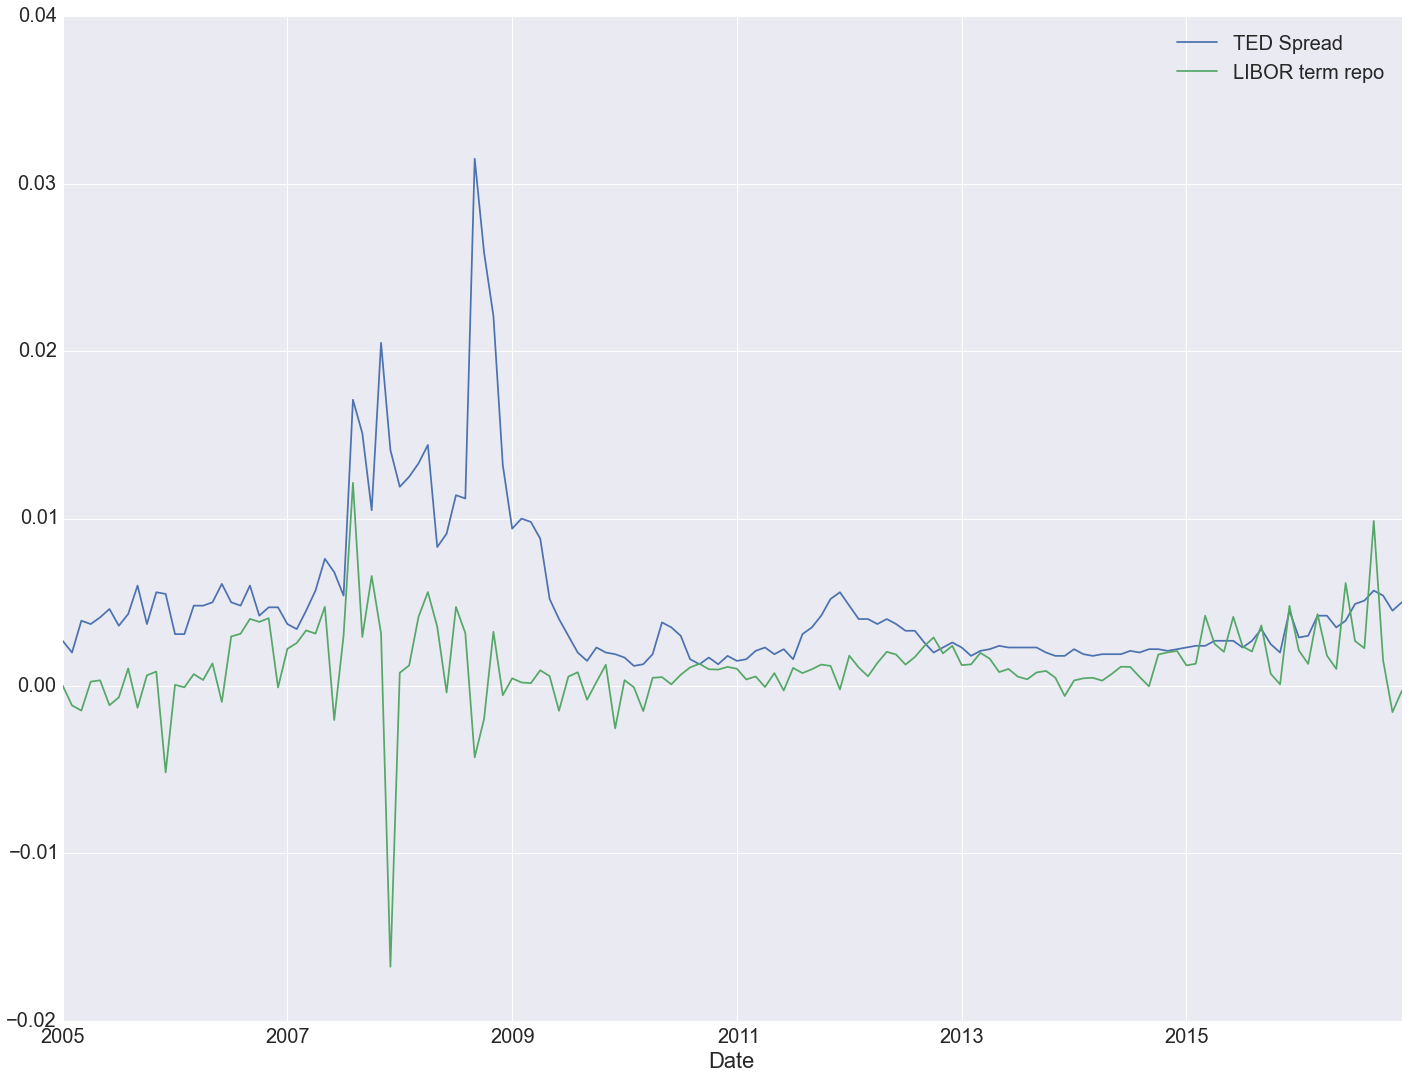

In [134]:
funding_liquidity.dropna().plot()

In [142]:
market_liquidity = pd.DataFrame()
market_liquidity['PS']=PS['Innovations in aggregate liquidity'].resample(rule='m',how='last')
market_liquidity['On versus off the run Treasuries']=on_off.resample(rule='m',how='last')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  This is separate from the ipykernel package so we can avoid doing imports until


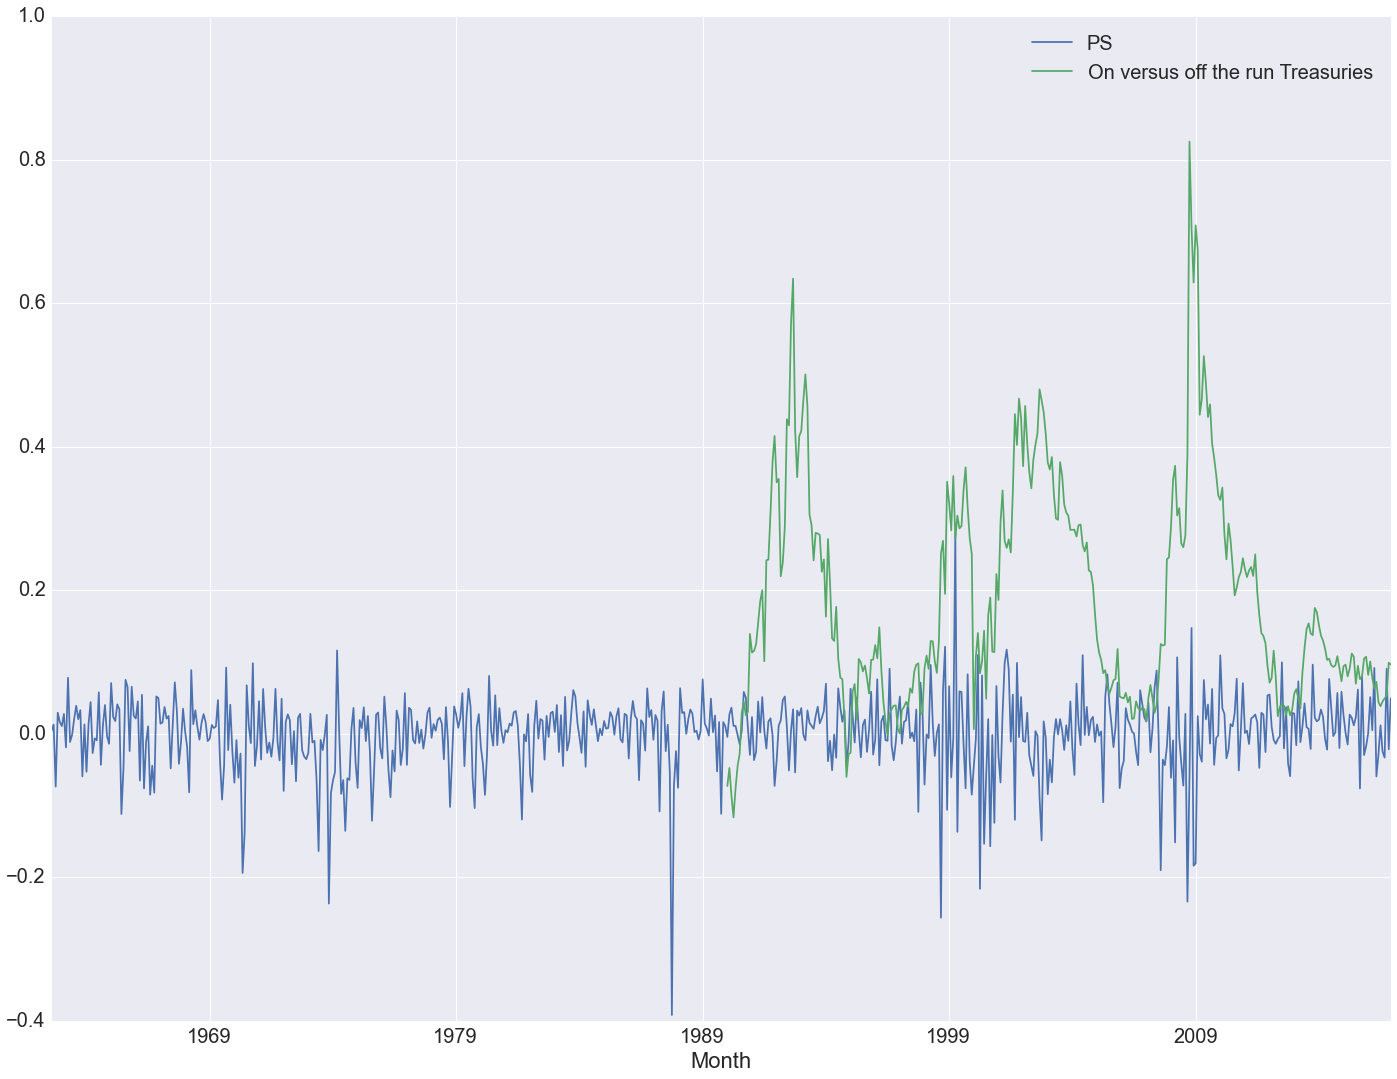

In [143]:
market_liquidity.plot()

# Determinents of Liquidity

In [245]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

In [246]:
#data=calc_zscore_ew(amihud.dropna(how='all')).dropna(how='all')
data=calc_zscore_expanding_window(amihud.dropna(how='all'),3).dropna(how='all')

In [247]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [248]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [249]:
sector_factor=pd.DataFrame()
for s in sector_PC.keys():
    sector_factor[s]=sector_PC[s][0]

# Market Liqudity for Amihud common factors across asset classes



# TODO: need to Newey West correct error terms 

In [250]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind=sector_factor[s].index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit()
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [251]:
results_df.T.round(2)

,Commodities,Equities,Currencies,Fixed Income
PS,8.02,-9.79,7.52,-6.08
PSTstats,2.52,-3.31,3.30,-3.01
On versus off the run Treasuries,-14.02,9.23,-9.06,7.01
On versus off the run TreasuriesTstats,-17.27,9.20,-13.53,10.85


# Funding Liqudity for Amihud common factors across asset classes

Note, since our repo data doesn't go back as long the we only look at it from 2005 to 2016


# TODO: need to Newey West correct error terms 

In [252]:
results_df=pd.DataFrame()
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=sector_factor[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit()
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  


In [253]:
results_df.T.round(2)

,Commodities,Equities,Currencies,Fixed Income
TED Spread,-135.94,118.51,-217.57,132.91
TED SpreadTstats,-3.03,2.81,-7.37,4.79
LIBOR term repo,70.22,-38.23,68.40,-75.13
LIBOR term repoTstats,0.88,-0.72,1.04,-1.35


# Run for unanticipated shocks from residuals from AR(2)

In [256]:
resid={}
for sector in sector_PC.keys():
    first_com=sector_PC[sector][0]
    temp=first_com.shift(2).dropna()
    #temp=first_com.diff().dropna()
    res=sm.OLS(temp,first_com.loc[temp.index]).fit()
    resid[sector]=res.resid
resid=pd.DataFrame(resid)

In [258]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind=resid[s].index
        # Please make the fit robust 
        res=sm.OLS(resid[s],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit()
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [259]:
results_df.T.round(2)

,Commodities,Equities,Currencies,Fixed Income
PS,0.74,0.52,-0.01,0.55
PSTstats,0.43,0.34,-0.00,0.29
On versus off the run Treasuries,-1.32,-2.23,4.20,1.56
On versus off the run TreasuriesTstats,-1.97,-3.92,4.21,2.14


In [262]:
results_df=pd.DataFrame()
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=resid[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(resid[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit()
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  


In [263]:
results_df.T.round(2)

,Commodities,Equities,Currencies,Fixed Income
TED Spread,110.36,66.26,-29.40,-32.61
TED SpreadTstats,4.72,3.16,-0.78,-1.22
LIBOR term repo,-7.20,-8.92,14.42,69.97
LIBOR term repoTstats,-0.17,-0.22,0.32,1.44


# FHT method

In [264]:
FHT=calculate_FHT(cleansed)

In [265]:
data=calc_zscore_expanding_window(FHT.dropna(how='all'),3).dropna(how='all')

In [266]:
sector_zscores={}
d_map=sector_map(amihud)
for sect in d_map.keys():
    sector_zscores[sect]=data[d_map[sect]].dropna(how='all')

In [267]:
sector_PC={}
sector_variance_explained=pd.DataFrame()

no_pc=3
for sect in d_map.keys():
    try: 
        PPCA=p.PPCA()
        PPCA.fit(np.array(sector_zscores[sect]),d=no_pc)
        sector_variance_explained[sect] = PPCA.var_exp
        pcs=pd.DataFrame()
        for i in range(0,no_pc,1):
            x=pd.DataFrame(PPCA.C.T[i]*PPCA.data).sum(axis=1)
            x.set_axis(sector_zscores[sect].index)
            pcs[i]=x
        sector_PC[sect] = pcs
    except:
        print sect

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [268]:
sector_factor=pd.DataFrame()
for s in sector_PC.keys():
    sector_factor[s]=sector_PC[s][0]

# Market liquidity
TODO: Make errors robus

In [269]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind2=market_liquidity[reg_fact].dropna().index
        ind=sector_factor[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s].loc[ind],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit()
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  


In [270]:
results_df.T.round(2)

,Commodities,Equities,Currencies,Fixed Income
PS,-10.55,16.74,6.17,-8.80
PSTstats,-3.89,4.57,3.67,-4.14
On versus off the run Treasuries,6.84,-8.71,-5.67,6.66
On versus off the run TreasuriesTstats,6.75,-6.25,-9.63,8.72


In [271]:
results_df=pd.DataFrame()
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in sector_factor.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=sector_factor[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(sector_factor[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit()
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  


In [272]:
results_df.T.round(2)

,Commodities,Equities,Currencies,Fixed Income
TED Spread,427.17,-538.68,-241.85,314.84
TED SpreadTstats,11.37,-10.21,-10.13,10.40
LIBOR term repo,-90.56,-55.07,38.99,-64.06
LIBOR term repoTstats,-0.77,-0.40,0.56,-0.78


# Run for unanticipated shocks from residuals from AR(2)


In [273]:
resid={}
for sector in sector_PC.keys():
    first_com=sector_PC[sector][0]
    temp=first_com.shift(2).dropna()
    #temp=first_com.diff().dropna()
    res=sm.OLS(temp,first_com.loc[temp.index]).fit()
    resid[sector]=res.resid
resid=pd.DataFrame(resid)

In [274]:
results_df=pd.DataFrame()
for reg_fact in market_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind=resid[s].index
        # Please make the fit robust 
        res=sm.OLS(resid[s],sm.add_constant(market_liquidity[reg_fact]).loc[ind]).fit()
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  del sys.path[0]


In [275]:
results_df.T.round(2)

,Commodities,Equities,Currencies,Fixed Income
PS,NaN,NaN,NaN,NaN
PSTstats,NaN,NaN,NaN,NaN
On versus off the run Treasuries,NaN,NaN,NaN,NaN
On versus off the run TreasuriesTstats,NaN,NaN,NaN,NaN


In [276]:
results_df=pd.DataFrame()
for reg_fact in funding_liquidity.columns:
    results_param=[]
    results_t=[]
    for s in resid.columns:
        ind2=funding_liquidity[reg_fact].dropna().index
        ind=resid[s].loc[ind2].dropna().index
        # Please make the fit robust 
        res=sm.OLS(resid[s].loc[ind],sm.add_constant(funding_liquidity[reg_fact]).loc[ind]).fit()
        results_param.append(res.params[reg_fact])
        results_t.append(res.tvalues[reg_fact])
    results_df[reg_fact]=pd.Series(results_param)
    results_df[reg_fact+'Tstats']=pd.Series(results_t)
results_df.set_axis(sector_factor.columns)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:14: FutureWarning: set_axis currently defaults to operating inplace.
This will change in a future version of pandas, use inplace=True to avoid this warning.
  


In [277]:
results_df.T.round(2)

,Commodities,Equities,Currencies,Fixed Income
TED Spread,81.47,-5.13,-171.44,44.91
TED SpreadTstats,2.14,-0.21,-3.09,1.45
LIBOR term repo,7.50,35.24,-51.93,35.36
LIBOR term repoTstats,0.08,0.63,-0.42,0.55
